# Preliminary Info

**Model - SimpleAvgEmbed :** Simply takes the average of all tokens' embeddings inside a cell and passes to the FF Linear Layer for a Naive binary classification.

**Data Hierarchy Train/Val/Test = (80-10-10) : big > medium > small > tiny > micro > teeny**
- **big** (800 - 100 - 100)
- **medium** (400 - 50 - 50)
- **small** (200 - 25 - 25)
- **tiny** (100 - 12 - 12)
- **micro** (50 - 6 - 6)
- **teeny** (25 - 3 - 3)


# Colab Setup

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Navigate to the directory
%cd /content/drive/My Drive/Coding/idea/modules/runcolab

/content/drive/My Drive/Coding/idea/modules/runcolab


# Setup

## Imports

In [2]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import sys
import os

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import the utilities and the dataloader
from utils import selfutil, trainutil, inferutil
from classes import SpreadsheetDataLoader, GeluAvgEmbed

# Now reload the modules to ensure they are up-to-date
importlib.reload(selfutil)
importlib.reload(trainutil)
importlib.reload(inferutil)
importlib.reload(SpreadsheetDataLoader)
importlib.reload(GeluAvgEmbed)

# Import the funcs needed from utils
from utils.selfutil import set_seed, get_vocab, get_fileList, create_embeddings
from utils.trainutil import train_model
from utils.inferutil import infer_one, infer_full

# Import the SpreadsheetDataLoader class
from classes.SpreadsheetDataLoader import SpreadsheetDataLoader
from classes.GeluAvgEmbed import GeluAvgEmbed

# Other regular imports
import torch.nn as nn
import torch
from tqdm import tqdm
import gc
import os
import pandas as pd
import math
import time
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter


# Setup device as a global constant
devstr = "cuda:0"  # Change to "cpu" or "mps" as needed
gpu = False if (devstr == 'cpu') else True

# Determine the device to use
if devstr.startswith('cuda') and torch.cuda.is_available():
    DEVICE = torch.device(devstr)
elif devstr.startswith('mps') and torch.backends.mps.is_available():
    DEVICE = torch.device(devstr)
else:
    DEVICE = 'cpu'  # Default to CPU if none of the above are available

# Determine the global count of threads to use in parallel operations
THREADS = 1

# Set the seed
set_seed(0)

print(DEVICE)

cuda:0


## Vocab/Embeddings

In [3]:
# Set the directory containing the spreadsheets for vocab training
vocab_dir = '../data/train_manual/'

# Get the vocabulary object and embeddings
spreadsheet_vocab = get_vocab(vocab_dir, 150000, space = True, case = 'both', threads = THREADS)
spreadsheet_wvs = create_embeddings(spreadsheet_vocab)

Getting Vocab: 100%|██████████| 40/40 [00:04<00:00,  8.21it/s]


40(P) = 40(G) + 0(E)
Unique Tokens: 5593
Vocab Size: 5597


Creating Word Embeddings: 100%|██████████| 5597/5597 [00:00<00:00, 56412.28it/s]

Word Embeddings Shape: torch.Size([5597, 50])


## File List and DataLoaders

In [4]:
# Define the directories
train_dir = '../data/train_manual/'
val_dir = '../data/val_manual/'
test_dir = '../data/test_manual/'

# Get the files for each directory
train_files = get_fileList(train_dir)
val_files = get_fileList(val_dir)
test_files = get_fileList(test_dir)

# Print the number of files in each list
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}\n")

# Decide max_rows, max_cols and num_tokens defaults 100, 100, 32
max_rows = 100
max_cols = 100
num_tokens = 32

# Create the data loaders
train_loader = SpreadsheetDataLoader(train_files, spreadsheet_vocab, max_rows, max_cols, num_tokens, threads = THREADS)
val_loader = SpreadsheetDataLoader(val_files, spreadsheet_vocab, max_rows, max_cols, num_tokens, threads = THREADS)
test_loader = SpreadsheetDataLoader(test_files, spreadsheet_vocab, max_rows, max_cols, num_tokens, threads = THREADS)

# Code to observe failed files
# if train_loader.failed_files:
#     print("Failed files in train_loader: {len(train_loader.failed_files)}")
#     for file in train_loader.failed_files:
#         print(file)

Train files: 40
Validation files: 5
Test files: 5



Processing files: 100%|██████████| 40/40 [00:00<00:00, 49.51it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 3337.82it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 3588.56it/s]



5(P) = 5(G) + 0(E)


# NEW MODEL DEFINITION

In [5]:
import torch
import torch.nn as nn
from tqdm import tqdm


class PosGeluAvgEmbed(nn.Module):

    # Initialize constructor
    def __init__(self, embedding_matrix, dropout_rate=0.05):

        super(PosGeluAvgEmbed, self).__init__()

        # Get the number of words in the vocabulary
        self.vocab_size = embedding_matrix.shape[0]

        # Get the embedding dimension for each word
        self.embedding_dim = embedding_matrix.shape[1]

        # Define an embedding layer initialized with pre-trained embeddings
        self._embed = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        # Define a dropout layer to prevent overfitting
        self._drop = nn.Dropout(dropout_rate)

        # Define a GELU activation layer for non-linearity
        self._non_linear = nn.GELU()

        # Define a linear layer to predict logits for bold/non-bold classification
        self._pred = nn.Linear(self.embedding_dim, 1)



    # def pos_embed(self, index):
    #     """
    #     Generate sinusoidal positional embeddings for a given row/column index.

    #     Args:
    #         index (int): Row or column index for which positional embedding is calculated.

    #     Returns:
    #         torch.Tensor: Positional embedding vector of size (embedding_dim,).
    #     """
    #     # Get positional dimension k
    #     k = torch.arange(0, self.embedding_dim, dtype=torch.float32, device=index.device)

    #     # Get the denominator
    #     denom = 10000 ** (k / self.embedding_dim)

    #     # Apply sin and get final position embedding
    #     pos_embedding = torch.sin(index.float() / denom)

    #     # Return the final position embedding
    #     return pos_embedding

    def pos_embed(self, index, axis, device):
        """
        Calculate sinusoidal positional embeddings, alternating sine and cosine for rows and columns.

        Args:
            index (int): Row or column index for which positional embedding is calculated.
            axis (str): 'row' or 'col' to determine which function to apply.
            device (torch.device): Device on which to calculate the embeddings.

        Returns:
            torch.Tensor: Positional embedding vector of size (embedding_dim,).
        """
        # Get positional dimension k
        k = torch.arange(0, self.embedding_dim, dtype=torch.float32, device=device)

        # Get the denominator
        denom = 10000 ** (k / self.embedding_dim)

        # Apply sine for rows and cosine for columns
        if axis == 'row':
            pos_embedding = torch.sin(index / denom)  # Use sine for rows
        elif axis == 'col':
            pos_embedding = torch.cos(index / denom)  # Use cosine for columns
        else:
            raise ValueError("Invalid axis value. Must be 'row' or 'col'.")

        return pos_embedding



    def forward(self, x):

        # Initialize an empty tensor to store predictions for all cells
        S_cube = torch.zeros((x.shape[0], x.shape[1], x.shape[2]), device=x.device)

        # Iterate over all cells in the 2D grid (100x100 cells)
        for cell in range(x.shape[1] * x.shape[2]):

            # Calculate the row and column indices for the current cell
            row = cell // x.shape[2]
            col = cell % x.shape[2]

            # Calculate the positional encodings for row/col
            row_pos_embed = self.pos_embed(row, axis='row', device=x.device)  # Sine for rows
            col_pos_embed = self.pos_embed(col, axis='col', device=x.device)

            # Extract token embeddings for the current cell
            token_embeddings = self._embed(x[:, row, col, :])  # Shape: batch x seq_len x embed_dim

            # Compute the average of token embeddings for the current cell
            averaged_embedding = token_embeddings.mean(dim=1)  # Shape: batch x embed_dim

            # Now compute the enriched embedding with the position embeddings added
            enriched_embedding = averaged_embedding + row_pos_embed + col_pos_embed

            # Apply dropout for regularization
            dropped_embedding = self._drop(enriched_embedding)  # Shape: batch x embed_dim

            # Apply GELU activation for non-linearity
            activated_embedding = self._non_linear(dropped_embedding)  # Shape: batch x embed_dim

            # Predict logits for bold/non-bold classification
            logits = self._pred(activated_embedding)  # Shape: batch x 1

            # Store the logits in the S_cube tensor
            S_cube[:, row, col] = logits.view(-1)

        # Return the final predictions for all cells
        return S_cube


In [6]:
# # Get a single batch to test with
# check_loader = torch.utils.data.DataLoader(train_loader, batch_size=1, shuffle=False)

# # Get one batch from the DataLoader
# batch = next(iter(check_loader))

# # Move the extracted x_tok to gpu
# exfile = batch['x_tok'].to(DEVICE)

# # Define model
# untrained_model = PosGeluAvgEmbed(spreadsheet_wvs).to(DEVICE)

# # Observe the model
# out = untrained_model.forward(exfile)

# print(f'Model Structure:\n{untrained_model}')
# print(out.shape)

# Model Training

## Define the model

In [7]:
# Define the untrained model and move it to the device
untrained_model = PosGeluAvgEmbed(spreadsheet_wvs).to(DEVICE)
print(f'Learnable Params: {sum(p.numel() for p in untrained_model.parameters() if p.requires_grad)}\n\n{untrained_model}')

Learnable Params: 279901

PosGeluAvgEmbed(
  (_embed): Embedding(5597, 50)
  (_drop): Dropout(p=0.05, inplace=False)
  (_non_linear): GELU(approximate='none')
  (_pred): Linear(in_features=50, out_features=1, bias=True)
)


# Training Loop

In [8]:
# Define the model training parameters
trained_model = train_model(
    model = untrained_model,
    train_data = train_loader,
    val_data = val_loader,
    DEVICE = DEVICE,
    batch_size = 40,
    lr = 5e-2,
    mu = 0.25,
    max_epochs = 20,
    patience = 2,
    save_int = 0,
    save_dir = '../models/',
    save_name = 'posgeluavgembed_manual'
)

Epoch 0


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


Train Loss: 1.9881953001022339, Perplexity: 1.0000198821506483
Val Loss: 0.8888740539550781, Perplexity: 1.0000088887800445


Epoch 1


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.61s/it]


Train Loss: 0.911827802658081, Perplexity: 1.0000091183195983
Val Loss: 0.6218317747116089, Perplexity: 1.0000062183370808


Epoch 2


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.73s/it]


Train Loss: 0.6250373721122742, Perplexity: 1.0000062503932547
Val Loss: 0.45718055963516235, Perplexity: 1.000004571816047


Epoch 3


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.63s/it]


Train Loss: 0.4702475666999817, Perplexity: 1.0000047024867236
Val Loss: 0.41636428236961365, Perplexity: 1.0000041636514916


Epoch 4


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.64s/it]


Train Loss: 0.4159042537212372, Perplexity: 1.0000041590511861
Val Loss: 0.34610748291015625, Perplexity: 1.0000034610808186


Epoch 5


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


Train Loss: 0.35551658272743225, Perplexity: 1.000003555172147
Val Loss: 0.33982741832733154, Perplexity: 1.0000033982799574


Epoch 6


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.75s/it]


Train Loss: 0.33958369493484497, Perplexity: 1.0000033958427152
Val Loss: 0.299452543258667, Perplexity: 1.0000029945299163


Epoch 7


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.73s/it]


Train Loss: 0.3063294589519501, Perplexity: 1.0000030632992813
Val Loss: 0.2969576418399811, Perplexity: 1.0000029695808277


Epoch 8


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.62s/it]


Train Loss: 0.2965756058692932, Perplexity: 1.0000029657604566
Val Loss: 0.2688307464122772, Perplexity: 1.0000026883110775


Epoch 9


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.59s/it]


Train Loss: 0.276189923286438, Perplexity: 1.000002761903047
Val Loss: 0.2660418450832367, Perplexity: 1.0000026604219898


Epoch 10


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.62s/it]


Train Loss: 0.2689885199069977, Perplexity: 1.0000026898888168
Val Loss: 0.2444583922624588, Perplexity: 1.0000024445869107


Epoch 11


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.61s/it]


Train Loss: 0.25284525752067566, Perplexity: 1.0000025284557716
Val Loss: 0.24184550344944, Perplexity: 1.000002418457959


Epoch 12


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


Train Loss: 0.2439262866973877, Perplexity: 1.000002439265842
Val Loss: 0.2244495302438736, Perplexity: 1.0000022444978214


Epoch 13


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.61s/it]


Train Loss: 0.23472324013710022, Perplexity: 1.000002347235156
Val Loss: 0.2222747653722763, Perplexity: 1.000002222750124


Epoch 14


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


Train Loss: 0.2260686606168747, Perplexity: 1.0000022606891614
Val Loss: 0.20725305378437042, Perplexity: 1.0000020725326855


Epoch 15


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.59s/it]


Train Loss: 0.21616555750370026, Perplexity: 1.0000021616579113
Val Loss: 0.2048332691192627, Perplexity: 1.0000020483347891


Epoch 16


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.68s/it]


Train Loss: 0.20966701209545135, Perplexity: 1.0000020966723189
Val Loss: 0.1921473741531372, Perplexity: 1.0000019214755875


Epoch 17


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.62s/it]


Train Loss: 0.20134951174259186, Perplexity: 1.0000020134971446
Val Loss: 0.18978071212768555, Perplexity: 1.000001897808922


Epoch 18


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.64s/it]


Train Loss: 0.19571682810783386, Perplexity: 1.0000019571701964
Val Loss: 0.17830179631710052, Perplexity: 1.0000017830195527


Epoch 19


Validation Processing: 100%|██████████| 1/1 [00:04<00:00,  4.64s/it]

Train Loss: 0.18665368854999542, Perplexity: 1.0000018665386274
Val Loss: 0.1753208190202713, Perplexity: 1.0000017532097272



TRAINING DONE at epoch 19, best epoch 19
Train Loss = 0.18665368854999542, Perplexity = 1.0000018665386274
Val Loss = 0.1753208190202713, Perplexity = 1.0000017532097272


# Evaluation

## Single File for Train/Val/Test


Filename: ../data/train_manual/advanced-placement-enrollment (1).xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(3,9): 0.900686
(3,10): 0.908573
(3,8): 0.914471
(5,20): 0.915429
(5,17): 0.916783
(5,9): 0.917841
(5,10): 0.918750
(5,18): 0.918899
(5,16): 0.920144
(5,8): 0.920627
(5,19): 0.922303
(3,16): 0.925154
(5,11): 0.926272
(5,15): 0.927097
(3,11): 0.927189
(4,11): 0.930677
(3,15): 0.931755
(5,14): 0.932089
(5,7): 0.932184
(3,7): 0.933598
(5,12): 0.933707
(5,13): 0.937027
(3,14): 0.938460
(3,12): 0.938929
(4,12): 0.939317
(5,6): 0.941155
(3,13): 0.942015
(4,9): 0.942416
(4,21): 0.942540
(3,6): 0.944657
(3,21): 0.944983
(4,20): 0.945276
(3,19): 0.945614
(4,6): 0.946021
(4,10): 0.946289
(4,19): 0.947289
(3,20): 0.947353
(4,16): 0.952103
(5,5): 0.952793
(3,5): 0.953509
(4,22): 0.954451
(4,5): 0.955256
(3,22): 0.955333
(4,15): 0.955473
(3,18): 0.962199
(4,8): 0.963724
(3,17): 0.963802
(4,18): 0.964032
(3,4): 0.964829
(4,17): 0.964952
(5,4): 0.965169
(4,14): 0.968029
(4,7): 0

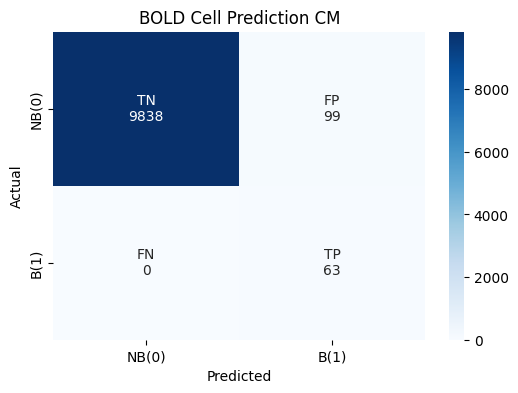


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0


In [13]:
infer_one(trained_model, train_loader, loc=30, disp_max = True, threshold = 0.9, condition = '>', device = DEVICE)


Filename: ../data/val_manual/portfolio-by-debt-size.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(4,18): 0.921704
(4,19): 0.925145
(0,9): 0.926085
(0,10): 0.926925
(0,16): 0.931795
(0,17): 0.932229
(4,15): 0.933637
(0,15): 0.933708
(0,11): 0.934047
(0,8): 0.934060
(0,18): 0.936313
(4,14): 0.938691
(0,14): 0.938777
(0,12): 0.940664
(0,19): 0.940944
(0,13): 0.942443
(0,7): 0.944139
(4,17): 0.944560
(4,9): 0.945086
(4,10): 0.945485
(4,8): 0.948724
(4,16): 0.949261
(0,6): 0.951108
(4,11): 0.952323
(4,12): 0.953999
(4,13): 0.955913
(4,7): 0.956075
(0,5): 0.957027
(5,17): 0.958192
(5,9): 0.959253
(5,19): 0.959898
(22,1): 0.961013
(21,1): 0.962117
(21,0): 0.962592
(4,6): 0.962621
(22,0): 0.963501
(5,15): 0.964026
(5,11): 0.964234
(20,1): 0.964435
(5,7): 0.964878
(0,4): 0.965430
(20,0): 0.965736
(19,1): 0.966566
(4,5): 0.966650
(11,1): 0.968369
(18,1): 0.968748
(5,13): 0.969058
(12,1): 0.970178
(19,0): 0.970217
(17,1): 0.970915
(11,0): 0.971128
(12,0): 0.971756
(18,0): 0.973267
(1

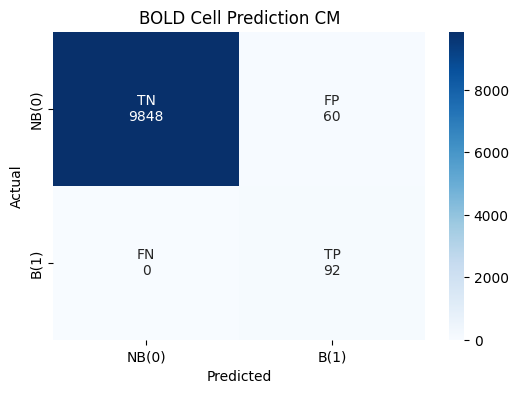


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
infer_one(trained_model, val_loader, loc=0, disp_max = True, threshold = 0.9, condition = '>', device = DEVICE)


Filename: ../data/test_manual/dlportfolio-by-school-type.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(0,9): 0.897559
(0,10): 0.897962
(0,11): 0.907373
(0,8): 0.908249
(4,9): 0.914191
(4,8): 0.920465
(0,7): 0.921076
(4,10): 0.921238
(0,6): 0.929988
(4,11): 0.930652
(4,7): 0.936375
(0,5): 0.938097
(4,6): 0.945860
(0,4): 0.950159
(4,5): 0.955559
(5,9): 0.956227
(5,11): 0.961481
(5,7): 0.962216
(20,1): 0.962901
(20,0): 0.964403
(0,3): 0.965687
(19,1): 0.967124
(4,4): 0.967732
(12,1): 0.968886
(19,0): 0.969006
(11,1): 0.969169
(18,1): 0.969657
(17,1): 0.970572
(11,0): 0.970709
(12,0): 0.971333
(18,0): 0.973267
(13,1): 0.973484
(16,1): 0.973578
(5,5): 0.974461
(10,1): 0.975110
(17,0): 0.975177
(15,1): 0.976152
(13,0): 0.976498
(10,0): 0.976788
(14,1): 0.976979
(16,0): 0.977732
(0,2): 0.978260
(4,3): 0.978676
(9,1): 0.979447
(14,0): 0.979452
(15,0): 0.979708
(5,10): 0.981139
(5,8): 0.981670
(9,0): 0.982345
(8,1): 0.983058
(0,1): 0.985395
(8,0): 0.985534
(7,1): 0.985596
(5,6): 0.

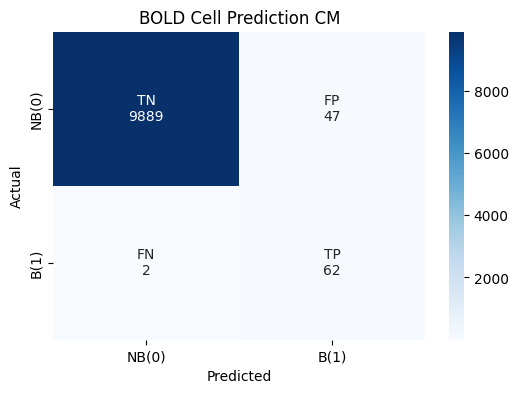


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11
0,1,1,1,1,1,1,1,1,1,0,0,1
1,1,1,1,1,1,0,0,0,0,0,0,0
2,1,1,1,1,1,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,0,0,0,0,0,0,0,0
7,1,1,1,1,0,0,0,1,0,0,0,0
8,1,1,1,1,0,0,0,0,0,0,0,0
9,1,1,1,1,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11
0,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0


In [17]:
infer_one(trained_model, test_loader, loc=0, disp_max = True, threshold = 0.9, condition = '>', device = DEVICE)

## Multi file for train/val/test



#########################################

Threshold = 0.9




Processing files: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]



--- Average Metrics Across All Files ---

Total Files Processed: 40

NB to B ratio: Predicted = 393193:6807 | Actual = 396714:3286
Accuracy: 99.07% | Precision: 47.97% | Recall: 97.69% | F1-Score: 0.64



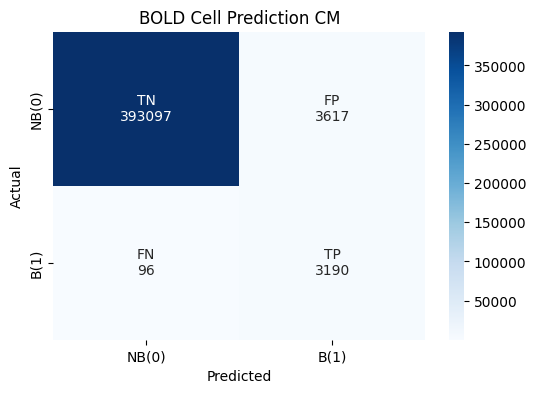

In [18]:
infer_full(trained_model, train_loader, is_subset=False, subset_size = 10, threshold=0.9, device=DEVICE, threads=THREADS)

Processing files: 100%|██████████| 5/5 [00:00<00:00, 6570.03it/s]



--- Average Metrics Across All Files ---

Total Files Processed: 5

NB to B ratio: Predicted = 49198:802 | Actual = 49602:398
Accuracy: 99.15% | Precision: 48.55% | Recall: 97.88% | F1-Score: 0.64



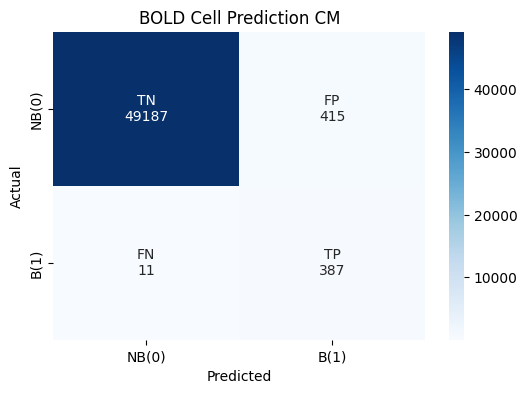

In [19]:
infer_full(trained_model, val_loader, is_subset=False, subset_size = 10, threshold=0.9, device=DEVICE, threads=THREADS)

Processing files: 100%|██████████| 5/5 [00:00<00:00, 3989.26it/s]



--- Average Metrics Across All Files ---

Total Files Processed: 5

NB to B ratio: Predicted = 49216:784 | Actual = 49606:394
Accuracy: 99.12% | Precision: 47.46% | Recall: 95.78% | F1-Score: 0.63



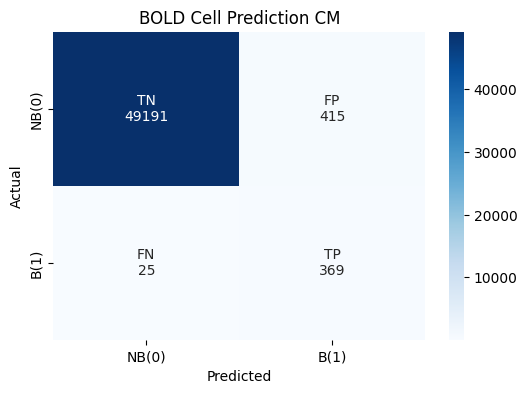

In [20]:
infer_full(trained_model, test_loader, is_subset=False, subset_size = 10, threshold=0.9, device=DEVICE, threads=THREADS)